In [88]:
from sklearn.datasets import make_circles

n_samples = 1000


X, y = make_circles(n_samples,
                    noise=0.03, 
                    random_state=42)

In [89]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [90]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [91]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

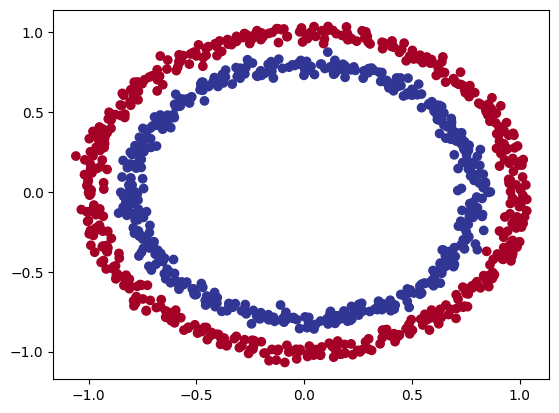

In [92]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [93]:
X.shape, y.shape

((1000, 2), (1000,))

In [94]:
import torch

x = torch.from_numpy(X).type(torch.float)

y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [95]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [96]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [97]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [98]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [99]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [100]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_0.parameters(), lr=0.1)

In [101]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc  = (correct/len(y_pred)) * 100
    return acc

In [102]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_0.train()
    
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
    
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")
           
    

Epoch: 0 | Train Loss: 0.69796 | Train Acc: 51.88 | Test Loss: 0.69440 | Test Acc: 58.00
Epoch: 10 | Train Loss: 0.69590 | Train Acc: 51.25 | Test Loss: 0.69305 | Test Acc: 53.00
Epoch: 20 | Train Loss: 0.69490 | Train Acc: 51.62 | Test Loss: 0.69254 | Test Acc: 49.50
Epoch: 30 | Train Loss: 0.69435 | Train Acc: 51.12 | Test Loss: 0.69236 | Test Acc: 49.50
Epoch: 40 | Train Loss: 0.69401 | Train Acc: 50.88 | Test Loss: 0.69232 | Test Acc: 51.00
Epoch: 50 | Train Loss: 0.69378 | Train Acc: 50.25 | Test Loss: 0.69234 | Test Acc: 50.00
Epoch: 60 | Train Loss: 0.69362 | Train Acc: 50.00 | Test Loss: 0.69239 | Test Acc: 51.50
Epoch: 70 | Train Loss: 0.69351 | Train Acc: 50.25 | Test Loss: 0.69246 | Test Acc: 51.00
Epoch: 80 | Train Loss: 0.69342 | Train Acc: 49.88 | Test Loss: 0.69254 | Test Acc: 50.00
Epoch: 90 | Train Loss: 0.69336 | Train Acc: 49.88 | Test Loss: 0.69262 | Test Acc: 53.00


In [103]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


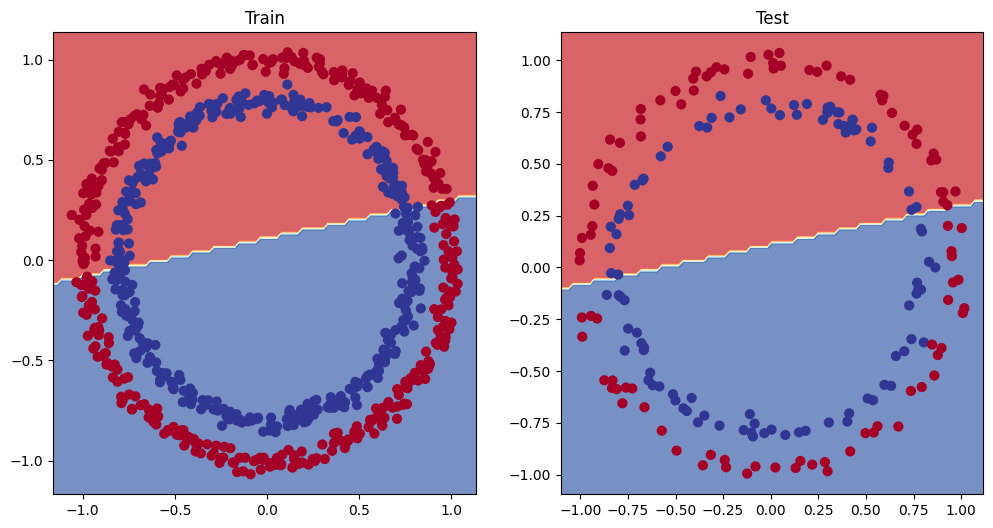

In [104]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

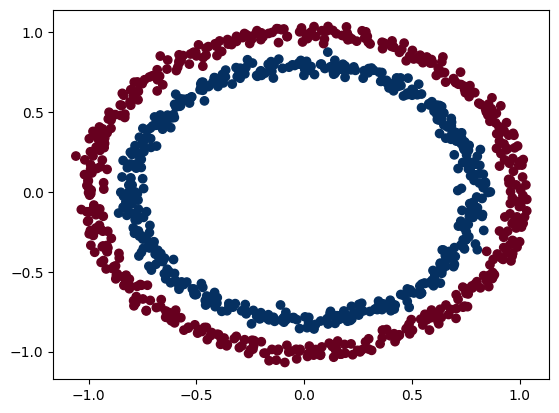

In [105]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [106]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

x_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [112]:
import torch.nn.functional as F
from torch import nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=5)
        self.layer3 = nn.Linear(in_features=5, out_features=5)
        self.layer4 = nn.Linear(in_features=5, out_features=1)
        


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x


In [113]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=1, bias=True)
)

In [114]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_1.parameters(), lr=0.3)

In [115]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_1.train()
    
    y_logits = model_1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    
    with torch.inference_mode():
        test_logits = model_1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")
           
    

Epoch: 0 | Train Loss: 0.69317 | Train Acc: 50.00 | Test Loss: 0.69320 | Test Acc: 50.00
Epoch: 10 | Train Loss: 0.69247 | Train Acc: 50.00 | Test Loss: 0.69258 | Test Acc: 50.00
Epoch: 20 | Train Loss: 0.69228 | Train Acc: 54.25 | Test Loss: 0.69235 | Test Acc: 52.00
Epoch: 30 | Train Loss: 0.69211 | Train Acc: 54.37 | Test Loss: 0.69214 | Test Acc: 51.00
Epoch: 40 | Train Loss: 0.69195 | Train Acc: 53.75 | Test Loss: 0.69192 | Test Acc: 52.00
Epoch: 50 | Train Loss: 0.69177 | Train Acc: 52.12 | Test Loss: 0.69168 | Test Acc: 54.00
Epoch: 60 | Train Loss: 0.69157 | Train Acc: 52.50 | Test Loss: 0.69140 | Test Acc: 54.00
Epoch: 70 | Train Loss: 0.69131 | Train Acc: 53.62 | Test Loss: 0.69108 | Test Acc: 57.00
Epoch: 80 | Train Loss: 0.69102 | Train Acc: 54.75 | Test Loss: 0.69074 | Test Acc: 56.50
Epoch: 90 | Train Loss: 0.69069 | Train Acc: 55.62 | Test Loss: 0.69037 | Test Acc: 57.00
Epoch: 100 | Train Loss: 0.69033 | Train Acc: 55.25 | Test Loss: 0.68996 | Test Acc: 56.50
Epoch: 110

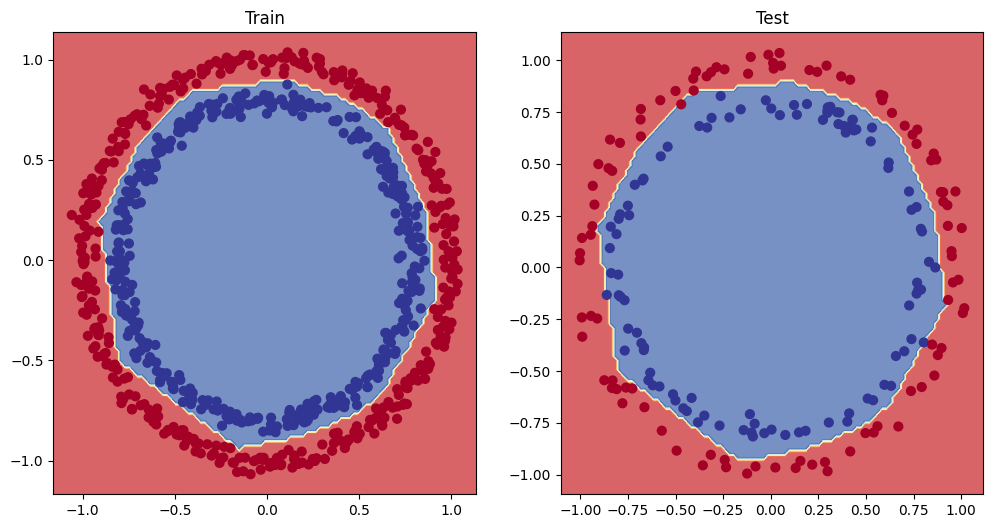

In [116]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test)